In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from scipy.stats import randint

In [9]:
housing = pd.read_csv("housing.csv")

# Preparing Data

### Creating Transformers

In [10]:
# Handling Missing Values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# Handling Categorical Data
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Handling Heavy-Tailed features
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, base=np.e):
        self.base = base
        

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.to_list()
        else:
            self.feature_names_in_ = [f"feature_{i}" for i in range(X.shape[1])]
        return self

    def transform(self, X):
        return np.emath.logn(self.base, X)
    
    def get_feature_names_out(self, input_features=None):
        if input_features == None:
            input_features = self.feature_names_in_
        return [f"log_{name}" for name in input_features]

    def inverse_transform(self, X):
        return self.base ** X
    
log_transformer = LogTransformer()

# Handling Geographic features


class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters,random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    
cluster_simil_transformer = ClusterSimilarity(random_state=42)

# Transforming housing_median_age
quantile_transformer = QuantileTransformer(output_distribution="normal", random_state=42)

# Creating Additional Features (bedrooms (bedrooms per room), rooms_per_house, people_per_house)
class RatioFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.to_list()
        else:
            self.feature_names_in_ = [f"feature_{i}" for i in range(X.shape[1])]
        return self
    
    def transform(self, X):
        if X.shape[1] < 2:             
            raise ValueError("Ratio transformation requires at least two columns.")
        transformed_X = X[:, 0] / X[:, 1]
        return transformed_X.reshape(-1,1)

    def get_feature_names_out(self, input_features=None):
        if input_features == None:
            input_features = self.feature_names_in_
        else:
            return [f"additional_{name}_ratio" for name in input_features]


ratio_features_transformer = RatioFeaturesTransformer()

# Scaling
standard_scaler = StandardScaler()

### Creating Pipeline

In [12]:
deafult_number_pipeline = make_pipeline(num_imputer, standard_scaler)

# Heavy-Tailed Features
log_pipeline = make_pipeline(num_imputer, log_transformer, standard_scaler)

# Categorical Features
cat_pipeline = make_pipeline(cat_imputer, cat_encoder)

# Geographic Features
geo_pipeline = Pipeline([("cluster_simil_transformer", cluster_simil_transformer)])

# median_house_values
quantile_pipeline = make_pipeline(num_imputer, quantile_transformer, standard_scaler)

# Additional Features
ratio_features_pipeline = make_pipeline(num_imputer, ratio_features_transformer,standard_scaler) 

# Piping!
preprocessing = ColumnTransformer([
    ("bedrooms",            ratio_features_pipeline,    ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house",     ratio_features_pipeline,    ["total_rooms", "households"]),
    ("people_per_house" ,   ratio_features_pipeline,    ["population", "households"]),
    ("log",                 log_pipeline,               ["total_rooms", "total_bedrooms", "population", "households", "median_income"]),
    ("geo",                 geo_pipeline,               ["latitude", "longitude"]),
    ("cat",                 cat_pipeline,               make_column_selector(dtype_include=object)),
    ("age",                 quantile_pipeline,          ["housing_median_age"])
    ], remainder=deafult_number_pipeline)

### Splitting Data

In [13]:
features = housing.drop(["median_house_value"], axis=1)
labels = housing["median_house_value"]


# Creating a custom stratification based on the median house value
labels_binned = pd.cut(labels, bins=20, labels=[x for x in range(1,21)])

# Splitting the data into training and testing sets using stratified sampling
X, X_test, y, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels_binned, random_state=42)


# Training Models

In [17]:
class Model():
    def __init__(self, preprocessor, predictor):
        self.predictor = make_pipeline(preprocessor, predictor)
        self.predictor_name = predictor.__class__.__name__

    def fit_predict(self, dataset, labels):
        self.predictor.fit(dataset, labels)
        self.predictions = self.predictor.predict(dataset)
        self.cv_rmses = -cross_val_score(self.predictor, dataset, labels, scoring="neg_root_mean_squared_error", cv=5)
        self.cv_rmse = self.cv_rmses.mean()
        self.rmse = root_mean_squared_error(labels, self.predictions)
        return f"{self.predictor_name}\tRMSE: {self.rmse:,.0f}\tCV_RMSE: {self.cv_rmse:,.0f}"



lin_reg = Model(preprocessing, LinearRegression())
tree_reg = Model(preprocessing, DecisionTreeRegressor(random_state=42))
forest_reg = Model(preprocessing, RandomForestRegressor(random_state=42))
sv_reg = Model(preprocessing, SVR(C=1.0, epsilon=0.1, kernel="rbf", degree=3, gamma="scale"))

results = []
results.append(lin_reg.fit_predict(dataset=X, labels=y))
results.append(tree_reg.fit_predict(dataset=X, labels=y))
results.append(forest_reg.fit_predict(dataset=X, labels=y))
results.append(sv_reg.fit_predict(dataset=X, labels=y))

for result in results:
    print(result)

LinearRegression	RMSE: 68,955	CV_RMSE: 71,648
DecisionTreeRegressor	RMSE: 0	CV_RMSE: 66,074
RandomForestRegressor	RMSE: 17,285	CV_RMSE: 47,140
SVR	RMSE: 118,139	CV_RMSE: 118,192


# Fine-Tuning Models

## Randomized Search

#### Utility function

In [14]:
def show_result(search):
    for param, value in search.best_params_.items():
        print(f"best {param.split('__')[-1]} found: {value}")
    print(f"best RMSE: {-search.best_score_:,.0f}")

### Linear Regressor Randomized Search

#### For Linear Regression, there are generally fewer hyperparameters to tune compared to models like Decision Trees, Random Forests, or SVR. Linear regression doesn't have parameters like max_depth or kernel, but we can still incorporate hyperparameter tuning by focusing on regularization techniques, like Ridge and Lasso regression, which are extensions of linear regression.

##### Simple linear regression Randomized Search

In [15]:
# Define the pipeline for Linear Regression
linear_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("linear_regression", LinearRegression())
])

# Define the parameter distribution (Linear Regression doesn't have many hyperparameters)
linear_param_distribs = {
    "preprocessing__geo__cluster_simil_transformer__n_clusters": randint(low=2, high=15),
}

# Set up RandomizedSearchCV
linear_rnd_search = RandomizedSearchCV(
    linear_pipeline,
    param_distributions=linear_param_distribs,
    n_iter=10, cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42
)

# Fit the randomized search to the data
linear_rnd_search.fit(X, y)
show_result(linear_rnd_search)

best n_clusters found: 14
best RMSE: 71,144


##### Lasso Regression Randomized Search

In [18]:
lasso_reg = Model(preprocessing, LassoCV())
print(lasso_reg.fit_predict(dataset=X, labels=y))

LassoCV	RMSE: 69,651	CV_RMSE: 70,587


In [19]:
# Define the pipeline for Lasso Regression
lasso_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(cv=5, random_state=42,
                      max_iter=10000, tol=1e-3
                      ))
])

# Define the parameter distribution for randomized search
lasso_param_distribs = {
    "preprocessing__geo__cluster_simil_transformer__n_clusters": randint(low=2, high=15),
}

# Set up RandomizedSearchCV
lasso_rnd_search = RandomizedSearchCV(
    lasso_pipeline,
    param_distributions=lasso_param_distribs,
    n_iter=10, cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42
)

# Fit the randomized search to the data
lasso_rnd_search.fit(X, y)
show_result(lasso_rnd_search)

best n_clusters found: 14
best RMSE: 69,735


##### Ridge Regression Randomized Search

In [20]:
ridge_reg = Model(preprocessing, Ridge())
print(ridge_reg.fit_predict(X,y))

Ridge	RMSE: 68,957	CV_RMSE: 71,570


In [21]:
ridge_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("standard_scaler",StandardScaler()),
    ("ridge", Ridge())
])

ridge_param_distribs = {
    "ridge__alpha": np.logspace(2, 3, 15),  # Regularization strength (alpha)
    "preprocessing__geo__cluster_simil_transformer__n_clusters": randint(low=2, high=15),
}

# Set up RandomizedSearchCV
ridge_rnd_search = RandomizedSearchCV(
    ridge_pipeline,
    param_distributions=ridge_param_distribs,
    n_iter=10, cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42
)

# Fit the randomized search to the data
ridge_rnd_search.fit(X, y)
show_result(ridge_rnd_search)

best n_clusters found: 14
best alpha found: 193.06977288832496
best RMSE: 69,477


### Decision Tree Regressor Randomized Search

In [43]:
# Define the pipeline for Decision Tree Regressor
tree_pipeline = Pipeline([
    ("preprocessing", preprocessing),  # Step for preprocessing
    ("decision_tree", DecisionTreeRegressor(random_state=42))  # Decision Tree Regressor with fixed random state for reproducibility
])

# Define the parameter distributions for randomized search
tree_param_distribs = {
    "decision_tree__max_depth": randint(low=3, high=15),       # Range of possible tree depths
    "decision_tree__min_samples_split": randint(low=2, high=10), # Minimum number of samples to split an internal node
    "decision_tree__min_samples_leaf": randint(low=3, high=15),  # Minimum number of samples allowed in a leaf node
    "decision_tree__max_features": randint(low=5, high=20),      # Number of features to consider for best split
    "preprocessing__geo__cluster_simil_transformer__n_clusters": randint(low=12, high=15)  # Number of clusters in the geo feature preprocessing step
}

# Set up RandomizedSearchCV with 5-fold cross-validation
tree_rnd_search = RandomizedSearchCV(
    tree_pipeline, param_distributions=tree_param_distribs, n_iter=10,
    cv=5, scoring='neg_root_mean_squared_error', random_state=42  # Using negative RMSE as scoring metric
)

# Fit the model to the data
tree_rnd_search.fit(X, y)
show_result(tree_rnd_search)

best max_depth found: 13
best max_features found: 15
best min_samples_leaf found: 10
best min_samples_split found: 6
best n_clusters found: 14
best RMSE: 55,285


### Random Forest Randomized Search

In [12]:
# Define the pipeline for Random Forest Regressor
forest_pipeline = Pipeline([
    ("preprocessing", preprocessing),  # Step for preprocessing
    ("random_forest", RandomForestRegressor(random_state=42))  # Random Forest Regressor with fixed random state for reproducibility
])

# Define the parameter distributions for randomized search
forest_param_distribs = {
    "random_forest__max_depth": randint(low=12, high=25),         # Range of possible tree depths in the forest
    "random_forest__max_features": randint(low=1, high=10),      # Number of features to consider at each split
    "random_forest__min_samples_split": randint(low=2, high=5),  # Minimum number of samples to split an internal node
    "random_forest__min_samples_leaf": randint(low=2, high=5),  # Minimum number of samples allowed in a leaf node
    "preprocessing__geo__cluster_simil_transformer__n_clusters": randint(low=13, high=24),  # Number of clusters in geo feature preprocessing
}


# Set up RandomizedSearchCV with 5-fold cross-validation
forest_rnd_search = RandomizedSearchCV(
    forest_pipeline, param_distributions=forest_param_distribs,
    n_iter=10, cv=5, scoring="neg_root_mean_squared_error", random_state=42  # Using negative RMSE as scoring metric
)

# Fit the model to the data
forest_rnd_search.fit(X, y)

show_result(forest_rnd_search)

best n_clusters found: 18
best max_depth found: 24
best max_features found: 9
best min_samples_leaf found: 2
best min_samples_split found: 4
best RMSE: 43,261


### Support Vector Regressor Randomized Search

In [23]:
# Define the pipeline for Support Vector Regressor (SVR)
svr_pipeline = Pipeline([
    ("preprocessing", preprocessing),  # Step for preprocessing
    ("svr", SVR())  # SVR model without fixed random state (no random_state parameter in SVR)
])

# Define the parameter distributions for randomized search
svr_param_distribs = {
    "svr__kernel": ["linear", "poly", "rbf", "sigmoid"],         # Various kernel types to explore
    "svr__C": np.logspace(-3, 3, 7),                             # Regularization parameter, using logspace for wide range of values
    "svr__epsilon": np.logspace(-4, 0, 5),                       # Epsilon-tube parameter for the loss function
    "svr__degree": randint(low=2, high=6),                       # Degree of the polynomial kernel function (if kernel='poly')
    "preprocessing__geo__cluster_simil_transformer__n_clusters": randint(low=2, high=15)  # Number of clusters in geo feature preprocessing
}

# Set up RandomizedSearchCV with 5-fold cross-validation
svr_rnd_search = RandomizedSearchCV(
    svr_pipeline, param_distributions=svr_param_distribs,
    n_iter=10, cv=5, scoring="neg_root_mean_squared_error", random_state=42  # Using negative RMSE as scoring metric
)

# Fit the model to the data
svr_rnd_search.fit(X, y)

show_result(svr_rnd_search)

best n_clusters found: 7
best C found: 10.0
best degree found: 5
best epsilon found: 0.0001
best kernel found: linear
best RMSE: 89,057


## Grid Search

### Simple Linear Regression Grid Search 

In [34]:
linear_param_grid = {
    "preprocessing__geo__cluster_simil_transformer__n_clusters": list(range(150, 220))  # Narrow search for clusters
    }

# Set up GridSearchCV with 5-fold cross-validation
linear_grid_search = GridSearchCV(
    linear_pipeline, param_grid=linear_param_grid,
    scoring="neg_root_mean_squared_error", cv=5, error_score="raise"
)

# Fit the model to the data
linear_grid_search.fit(X, y)
    
show_result(linear_grid_search)

best n_clusters found: 170
best RMSE: 62,754


### Lasso Regression Grid Search

In [68]:
lasso_param_grid = {

    "preprocessing__geo__cluster_simil_transformer__n_clusters": [14, 30, 50, 100, 150, 160, 163] # Narrow search for clusters
}

    # Set up GridSearchCV with 5-fold cross-validation
lasso_grid_search = GridSearchCV(
    lasso_pipeline, param_grid=lasso_param_grid,
    scoring="neg_root_mean_squared_error", cv=5, error_score="raise"
)

# Fit the model to the data
lasso_grid_search.fit(X, y)

        
show_result(lasso_grid_search)

best n_clusters found: 163
best RMSE: 67,006


### Ridge Regression Grid Search 

In [54]:
ridge_param_grid = {
        "ridge__alpha": [63.69-50, 63.69, 63.69+50],  # Refine around the best alpha found
        "preprocessing__geo__cluster_simil_transformer__n_clusters": [6300] # Narrow search for clusters
}

    # Set up GridSearchCV with 5-fold cross-validation
ridge_grid_search = GridSearchCV(
    ridge_pipeline, param_grid=ridge_param_grid,
    scoring="neg_root_mean_squared_error", cv=5, error_score="raise"
)

# Fit the model to the data
ridge_grid_search.fit(X, y)

        
show_result(ridge_grid_search)
# Update the parameters

best n_clusters found: 6300
best alpha found: 63.69
best RMSE: 64,995


### Decision Tree Regressor Grid Search

In [45]:
# These parameters are fine-tuned based on results from the previous random search
tree_param_grid = [
    {
        "decision_tree__max_depth": [13], # Max depth of the tree: limits how deep the tree can grow
        "decision_tree__max_features": [15], # Number of features to consider at each split
        "decision_tree__min_samples_leaf": [10],  # Controls overfitting by ensuring minimum samples at leaf nodes
        "decision_tree__min_samples_split": [6], # Ensures a node can only split if it has enough samples
        "preprocessing__geo__cluster_simil_transformer__n_clusters": [14],
    }
]

# This is a follow-up to the random search, aiming to find the optimal parameters in a more focused manner
tree_grid_search = GridSearchCV(
    tree_pipeline,  # Pipeline that includes preprocessing and model
    tree_param_grid,  # Parameter grid to search through
    refit=True,  # Refits the best model found on the entire dataset after grid search
    scoring="neg_root_mean_squared_error",  # Scoring metric to evaluate performance
    cv=5,  # Number of cross-validation folds
    error_score="raise"  # Raise an error if fitting fails for a given parameter combination
)

tree_grid_search.fit(X, y)
show_result(tree_grid_search)

best max_depth found: 13
best max_features found: 15
best min_samples_leaf found: 10
best min_samples_split found: 6
best n_clusters found: 14
best RMSE: 55,285


In [47]:
(tree_md, tree_mf, tree_msl, tree_mss, tree_nc) = (0, 0, 0, 0, 0)  # Initial parameter values

tree_best_params = tree_grid_search.best_params_  # Retrieve best parameters from the initial grid search

# Initialize flag to control the loop (set to False initially to ensure loop runs)
flag = False  

while not flag:
    # Update parameters with the best ones found so far using max() to ensure valid values
    tree_md = max(tree_best_params['decision_tree__max_depth'], 2)  # Ensure max_depth is at least 1 (we use [tree_med-1,...] in the param grid)
    tree_mss = max(tree_best_params['decision_tree__min_samples_split'], 3)  # Ensure min_samples_split is at least 2
    tree_msl = max(tree_best_params['decision_tree__min_samples_leaf'], 2)  # Ensure min_samples_leaf is at least 1
    tree_mf = max(tree_best_params['decision_tree__max_features'], 2)  # Ensure max_features is at least 1
    tree_nc = max(tree_best_params['preprocessing__geo__cluster_simil_transformer__n_clusters'], 3)  # Ensure n_clusters is at least 2
    
    # Define the new, smaller grid around the current best parameters
    tree_param_grid = [
        {
            "decision_tree__max_depth": [tree_md-1, tree_md, tree_md+1],     
            "decision_tree__min_samples_split": [tree_mss-1, tree_mss, tree_mss+1],     
            "decision_tree__min_samples_leaf": [tree_msl-1, tree_msl, tree_msl+1],     
            "decision_tree__max_features": [tree_mf-1, tree_mf, tree_mf+1],
            "preprocessing__geo__cluster_simil_transformer__n_clusters": [tree_nc-1, tree_nc, tree_nc+1],
        }
    ]
    
    # Perform a new grid search with the refined parameter grid
    tree_grid_search = GridSearchCV(
        tree_pipeline, tree_param_grid, refit=True, scoring="neg_root_mean_squared_error", cv=5, error_score="raise"
    )
    
    tree_grid_search.fit(X, y)
    
    # Get the new best parameters after this iteration
    new_best_params = tree_grid_search.best_params_
    
    # Check if parameters have stopped changing (i.e., they are equal to the previous best)
    flag = tree_best_params == new_best_params
    
    # Update the best parameters for the next iteration if flag is still False
    tree_best_params = new_best_params
    show_result(tree_grid_search)
# After the loop exits, we will have the most fine-tuned parameters in tree_best_params
show_result(tree_grid_search)

best max_depth found: 12
best max_features found: 14
best min_samples_leaf found: 9
best min_samples_split found: 2
best n_clusters found: 14
best RMSE: 54,910


### Random Forest Grid Search

In [68]:
# These parameters are fine-tuned based on results from the previous Random Search for Random Forest

forest_param_grid = [
    {
        "random_forest__max_depth": [17, 18, 19], # 24, 23, 22, 21, 20, 19, 18
        "random_forest__max_features": [5, 6, 7], # 9, 8, 7, 6
        "random_forest__min_samples_leaf": [2, 3], # 2
        "random_forest__min_samples_split": [2, 3], # 4, 3, 2
        "preprocessing__geo__cluster_simil_transformer__n_clusters": [19, 20, 21], #18, 19, 20
    }
]

# Initialize GridSearchCV to perform grid search over the specified parameters
forest_grid_search = GridSearchCV(
    forest_pipeline,
    forest_param_grid,
    refit=True,
    scoring="neg_root_mean_squared_error",  # cross-validation is being applied to evaluate the model's performance
                                            # using the negative root mean squared error (RMSE) as the scoring metric
    cv=5,  # Number of cross-validation folds
    error_score="raise"  # Raise an error if fitting fails for a given parameter combination
)

forest_grid_search.fit(X, y)
show_result(forest_grid_search)

best n_clusters found: 20
best max_depth found: 18
best max_features found: 6
best min_samples_leaf found: 2
best min_samples_split found: 2
best RMSE: 42,613


### Support Vector Regressor Grid Search

In [30]:
# Use the best parameters from RandomizedSearchCV
best_n_clusters = 7
best_C = 10.0
best_degree = 5
best_epsilon = 0.0001
best_kernel = 'linear'

# Define the parameter grid for GridSearchCV
svr_param_grid = {
    "svr__kernel": [best_kernel],  # Fixed to the best kernel ('linear' in this case)
    "svr__C": [best_C / 2, best_C, best_C * 2],  # Refine around the best C found
    "svr__epsilon": [best_epsilon / 10, best_epsilon, best_epsilon * 10],  # Fine-tune epsilon
    "svr__degree": [best_degree - 1, best_degree, best_degree + 1],  # Only matters for 'poly', kept for generality
    "preprocessing__geo__cluster_simil_transformer__n_clusters": [best_n_clusters - 1, best_n_clusters, best_n_clusters + 1]  # Narrow search for clusters
}

# Set up GridSearchCV with 5-fold cross-validation
svr_grid_search = GridSearchCV(
    svr_pipeline, param_grid=svr_param_grid,
    scoring="neg_root_mean_squared_error", cv=5, error_score="raise"
)

# Fit the model to the data
svr_grid_search.fit(X, y)

# Display the results
show_result(svr_grid_search)

best n_clusters found: 8
best C found: 20.0
best degree found: 4
best epsilon found: 1e-05
best kernel found: linear
best RMSE: 83,267


## Assessing the best model with the testing dataset

In [11]:
forest_pipeline = Pipeline([
    ("preprocessing", preprocessing),  # Step for preprocessing
    ("random_forest", RandomForestRegressor(max_depth=24, 
        max_features=9, 
        min_samples_leaf=2,
        min_samples_split=4,
        random_state=42
        ))  # Random Forest Regressor with fixed random state for reproducibility
])

# I use grid search again because I have to set the n_cluster hyperparameter to 19
forest_param_grid = [
    {
        "preprocessing__geo__cluster_simil_transformer__n_clusters": [19],
    }
]

# Initialize GridSearchCV to perform grid search over the specified parameters
forest_grid_search = GridSearchCV(
    forest_pipeline,
    forest_param_grid,
    refit=True,
    scoring="neg_root_mean_squared_error",  # cross-validation is being applied to evaluate the model's performance
                                            # using the negative root mean squared error (RMSE) as the scoring metric
    cv=5,  # Number of cross-validation folds
    error_score="raise"  # Raise an error if fitting fails for a given parameter combination
)

forest_grid_search.fit(X_test, y_test)
show_result(forest_grid_search)

best n_clusters found: 19
best RMSE: 49,455


## Comparing the Four Regressors

### Testing Linear Regression

In [71]:
linear_param_grid = {
    "preprocessing__geo__cluster_simil_transformer__n_clusters": [170]  # Narrow search for clusters
    }

# Set up GridSearchCV with 5-fold cross-validation
linear_grid_search = GridSearchCV(
    linear_pipeline, param_grid=linear_param_grid,
    scoring="neg_root_mean_squared_error", cv=5, error_score="raise"
)

# Fit the model to the data
linear_grid_search.fit(X_test, y_test)
    
show_result(linear_grid_search)

best n_clusters found: 170
best RMSE: 75,135


### Testing Decision Tree Regression

In [76]:
tree_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("decision_tree", DecisionTreeRegressor(
        max_depth=12, 
        max_features=14, 
        min_samples_leaf=9, 
        min_samples_split=2,
        random_state=42
        )
    )
])

tree_param_grid = [
    {
        "preprocessing__geo__cluster_simil_transformer__n_clusters": [14], # best found
    }
]


tree_grid_search = GridSearchCV(
    tree_pipeline,
    tree_param_grid, 
    refit=True, 
    scoring="neg_root_mean_squared_error",  
    cv=5,  
    error_score="raise" 
)

tree_grid_search.fit(X_test, y_test)
show_result(tree_grid_search)

best n_clusters found: 14
best RMSE: 64,624


### Testing SVR

In [79]:
svr_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("svr", SVR(kernel= "linear", C=20.0, degree=4, epsilon=1e-05)) 
])

svr_param_grid = [
    {
        "preprocessing__geo__cluster_simil_transformer__n_clusters": [8], # best found
    }
]

svr_grid_search = GridSearchCV(
    svr_pipeline,
    svr_param_grid, 
    refit=True, 
    scoring="neg_root_mean_squared_error",  
    cv=5,  
    error_score="raise" 
)

svr_grid_search.fit(X_test, y_test)
show_result(svr_grid_search)

best n_clusters found: 8
best RMSE: 97,450


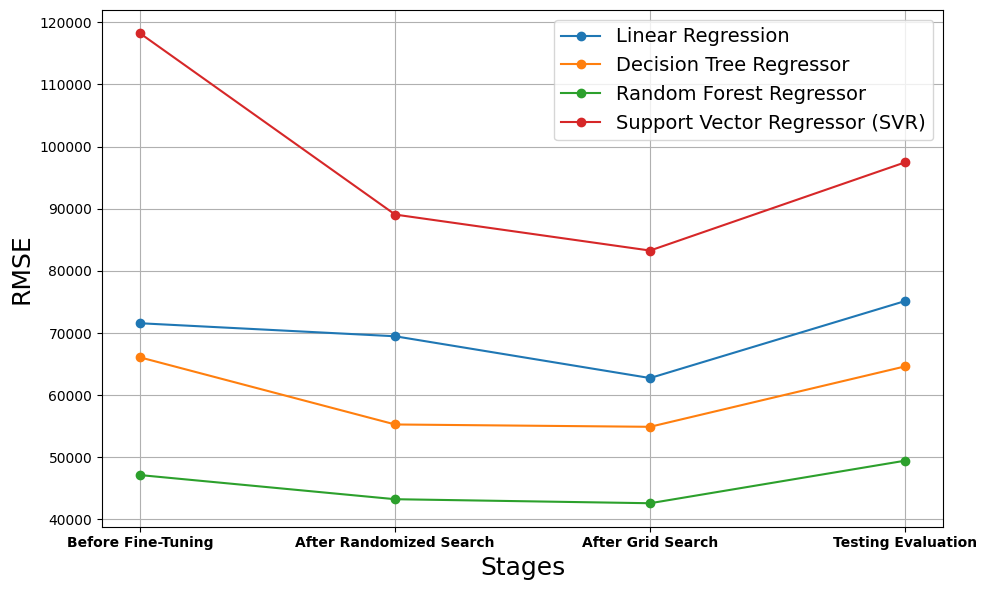

In [85]:
data = {
    "Linear Regression":              [71570, 69477, 62754, 75135],
    "Decision Tree Regressor":        [66074, 55285, 54910, 64624],
    "Random Forest Regressor":        [47140, 43261, 42613, 49455],
    "Support Vector Regressor (SVR)": [118192, 89057, 83267, 97450],
}

# Stages
stages = ['Before Fine-Tuning', 'After Randomized Search', 'After Grid Search']

# Plotting
plt.figure(figsize=(10, 6))

# Iterate through the data and plot each series
for regressor, rmse_values in data.items():
    # Adjust the x-values to account for the varying number of RMSE values for Random Forest Regressor
    if regressor == "Random Forest Regressor":
        x_values = list(range(len(rmse_values)))
        plt.plot(x_values, rmse_values, marker='o', label=regressor)
        # Add labels for the x-values
        plt.xticks(x_values, stages + ['Testing Evaluation'])
    else:
        plt.plot(range(len(rmse_values)), rmse_values, marker='o', label=regressor)

plt.xlabel('Stages', fontsize=18)
plt.ylabel('RMSE', fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=10, fontweight="bold")
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

## Comparing the Linear Regressors

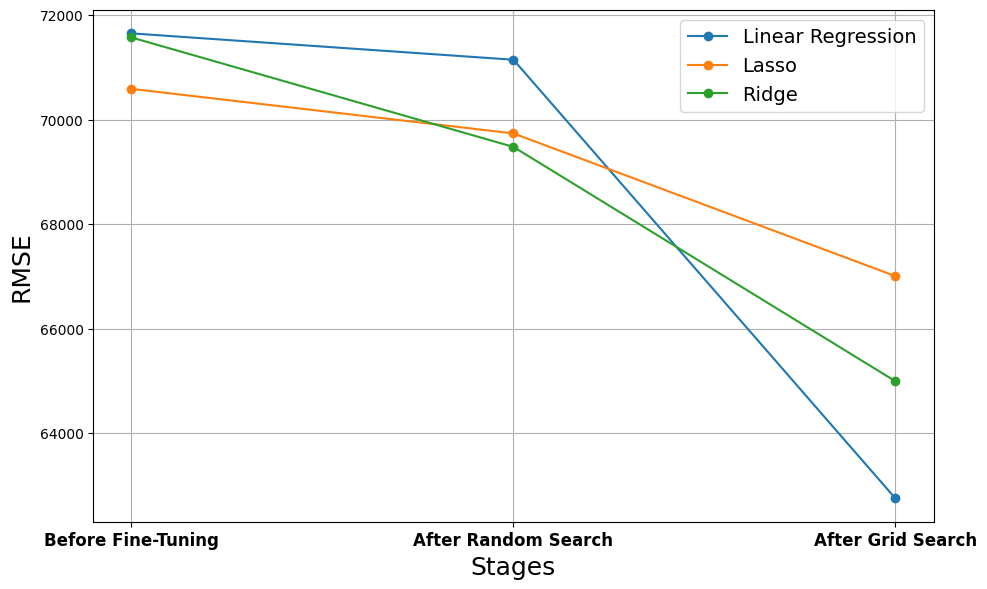

In [87]:
# Data for linear regression models
linear_data = {
    "Linear Regression": [71648, 71144, 62754],
    "Lasso": [70587, 69735, 67006],
    "Ridge": [71570, 69477, 64995],
}

# Stages
tuning_stages = ['Before Fine-Tuning', 'After Random Search', 'After Grid Search']

# Plotting
plt.figure(figsize=(10, 6))

# Iterate through the data and plot each series
for regressor, rmse_values in linear_data.items():
    # For the Ridge model, add an additional label for grid search
    if regressor == "Ridge":
        plt.plot(range(len(rmse_values)), rmse_values, marker='o', label=regressor)
        plt.xticks(range(len(rmse_values)), tuning_stages[:len(rmse_values)], fontsize=12)  # Adjust x-ticks
    else:
        plt.plot(range(len(rmse_values)), rmse_values, marker='o', label=regressor)
        plt.xticks(range(len(rmse_values)), tuning_stages[:len(rmse_values)], fontsize=12)  # Adjust x-ticks

# Labels
plt.xlabel('Stages', fontsize=18)
plt.ylabel('RMSE', fontsize=18)

plt.legend(fontsize=14)
plt.xticks(fontsize=12, fontweight="bold")

# Grid and layout
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()